# Importance Sampling Examples

In [1]:
from qmcpy import *
from numpy import *
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

## Game Example
Consider a game where $X_1, X_2 \overset{\textrm{IID}}{\sim} \mathcal{U}[0,1]$ are drawn with a payoff of 
\begin{equation}
Y = \text{payoff}(X_1,X_2) = \begin{cases} \$10, & 1.7 \le X_1 + X_2 \le 2, \\ 0, & 0 \le X_1 + X_2 < 1.7, \end{cases}
\end{equation}
What is the expected payoff of this game?

In [2]:
payoff = lambda x: 10*(x.sum(1)>1.7)
abs_tol = 1e-3

### Vanilla Monte Carlo 
With ordinary Monte Carlo we do the following:
$$\mu = \mathbb{E}(Y) = \int_{[0,1]^2} \text{payoff}(x_1,x_2) \,
\mathrm{d} x_1 \mathrm{d}x_2$$

In [3]:
distribution = Lattice(2)
measure = Uniform(distribution)
integral = QuickConstruct(measure,payoff)
solution1,data1 = CubLattice_g(integral, abs_tol, check_cone=False).integrate()
data1

Solution: 0.4500         
QuickConstruct (Integrand Object)
Lattice (DiscreteDistribution Object)
	dimension       2
	scramble        1
	replications    0
	seed            None
	backend         gail
	mimics          StdUniform
Uniform (TrueMeasure Object)
	distrib_name    Lattice
	lower_bound     0
	upper_bound     1
CubLattice_g (StoppingCriterion Object)
	abs_tol         0.001
	rel_tol         0
	n_init          1024
	n_max           34359738368
CubatureData (AccumulateData Object)
	n_total         65536
	solution        0.450
	r_lag           4
	time_integrate  0.071

### Monte Carlo with Importance Sampling
We may add the importance sampling to increase the number of samples with positive payoffs. Let 
$$\boldsymbol{Z} = (X_1^{1/(p+1)}, X_2^{1/(p+1)}), \qquad \boldsymbol{X} \sim \mathcal{U}[0,1]^2$$
This means that $Z_1$ and $Z_2$ are IID with common CDF $F(z) =z^{p+1}$ and common PDF $\varrho(z) = (p+1)z^{p}$.
Thus,
$$\mu = \mathbb{E}(Y) = \int_{[0,1]^2} \frac{\text{payoff}(z_1,z_2)}{(p+1)^2(z_1z_2)^{p}} \, \varrho(z_1)
\varrho(z_2) \, \mathrm{d} z_1 \mathrm{d}z_2 = \int_{[0,1]^2}
\frac{\text{payoff}(x_1^{1/(p+1)},x_2^{1/(p+1)})}{(p+1)^2(x_1x_2)^{p/(p+1)}}
\, \mathrm{d} x_1 \mathrm{d}x_2$$

In [4]:
p = 1
distribution = Lattice(2)
measure = Uniform(distribution)
integral = QuickConstruct(measure,lambda x: payoff(x**(1/(p+1))) / ((p+1)**2 * (x.prod(1))**(p/(p+1))))
solution2,data2 = CubLattice_g(integral, abs_tol, check_cone=False).integrate()
data2

Solution: 0.4499         
QuickConstruct (Integrand Object)
Lattice (DiscreteDistribution Object)
	dimension       2
	scramble        1
	replications    0
	seed            None
	backend         gail
	mimics          StdUniform
Uniform (TrueMeasure Object)
	distrib_name    Lattice
	lower_bound     0
	upper_bound     1
CubLattice_g (StoppingCriterion Object)
	abs_tol         0.001
	rel_tol         0
	n_init          1024
	n_max           34359738368
CubatureData (AccumulateData Object)
	n_total         16384
	solution        0.450
	r_lag           4
	time_integrate  0.021

In [5]:
print('Imporance Sampling takes %.3f the time and %.3f the samples'%\
     (data2.time_integrate/data1.time_integrate,data2.n_total/data1.n_total))

Imporance Sampling takes 0.298 the time and 0.250 the samples


## Asian Call Option Example
The stock price must raise significantly for the payoff to be positive.
So we will give a upward drift to the Brownian motion that defines the
stock price path.  We can think of the option price as the
multidimensional integral
\begin{equation*} 
\mu = \mathbb{E}[f(\boldsymbol{X})] = \int_{\mathbb{R}^d}
f(\boldsymbol{x}) 
\frac{\exp\bigl(-\frac12 \boldsymbol{x}^T\mathsf{\Sigma}^{-1}
\boldsymbol{x}\bigr)}
{\sqrt{(2 \pi)^{d} \det(\mathsf{\Sigma})}} \, \mathrm{d} \boldsymbol{x} ,
\end{equation*} 

where

\begin{align*} 
\boldsymbol{X} & \sim \mathcal{N}(\boldsymbol{0}, \mathsf{\Sigma}), \qquad
\mathsf{\Sigma} = \bigl(\min(j,k)T/d \bigr)_{j,k=1}^d, \\
d & =  13 \text{ in this case} \\
f(\boldsymbol{x}) & = \max\biggl(K - \frac 1d \sum_{j=1}^d
S(jT/d,\boldsymbol{x}), 0 \biggr) \mathrm{e}^{-rT}, \\
S(jT/d,\boldsymbol{x}) &= S(0) \exp\bigl((r - \sigma^2/2) jT/d +
\sigma x_j\bigr).
\end{align*} 

We will replace $\boldsymbol{X}$ by 

$$\boldsymbol{Z} \sim \mathcal{N}(\boldsymbol{a}, \mathsf{\Sigma}),
\qquad \boldsymbol{a} = (aT/d)(1, \ldots, d)$$

where a positive $a$ will create more positive payoffs.  This
corresponds to giving our Brownian motion a drift.  To do this we
re-write the integral as 

\begin{gather*} 
\mu = \mathbb{E}[f_{\mathrm{new}}(\boldsymbol{Z})] 
= \int_{\mathbb{R}^d}
f_{\mathrm{new}}(\boldsymbol{z}) 
\frac{\exp\bigl(-\frac12 (\boldsymbol{z}-\boldsymbol{a})^T
\mathsf{\Sigma}^{-1}
(\boldsymbol{z} - \boldsymbol{a}) \bigr)}
{\sqrt{(2 \pi)^{d} \det(\mathsf{\Sigma})}} \, \mathrm{d} \boldsymbol{z} ,
\\
f_{\mathrm{new}}(\boldsymbol{z}) = 
f(\boldsymbol{z}) 
\frac{\exp\bigl(-\frac12 \boldsymbol{z}^T
\mathsf{\Sigma}^{-1} \boldsymbol{z} \bigr)}
{\exp\bigl(-\frac12 (\boldsymbol{z}-\boldsymbol{a})^T
\mathsf{\Sigma}^{-1}
(\boldsymbol{z} - \boldsymbol{a}) \bigr)}
= f(\boldsymbol{z}) \exp\bigl((\boldsymbol{a}/2 - \boldsymbol{z})^T
\mathsf{\Sigma}^{-1}\boldsymbol{a} \bigr)
\end{gather*} 

Finally note that 

$$\mathsf{\Sigma}^{-1}\boldsymbol{a} = \begin{pmatrix} 0 \\ 0 \\ \vdots
\\ 0 \\ a \end{pmatrix}, \qquad f_{\mathrm{new}}(\boldsymbol{z}) =
f(\boldsymbol{z}) \exp\bigl((aT/2 - z_d)a \bigr)$$

This drift in the Brownian motion may be implemented by changing the `mean_shift_is` input to the `BrownianMotion` object.

In [6]:
abs_tol = 1e-2
dimension = 32
time_vector = [i/dimension for i in range(1,dimension+1)]
def plt_bm_is(measure):
    n_plt = 32
    samples = measure.gen_mimic_samples(n_min=0,n_max=n_plt)
    fig,ax = plt.subplots()
    for i in range(n_plt): ax.plot(time_vector,samples[i])
    ax.set_xlabel('time')
    ax.set_ylabel('option price')
    ax.set_title('Brownian Motion with Mean Shift %.1f'%measure.mean_shift_is)
    plt.show()

### Vanilla Monte Carlo

In [7]:
distribution = Sobol(dimension)
measure = BrownianMotion(distribution,time_vector)
integrand = AsianCall(measure)
solution1,data1 = CubSobol_g(integrand, abs_tol, check_cone=False).integrate()
data1

Solution: 1.7771         
AsianCall (Integrand Object)
	volatility      0.500
	start_price     30
	strike_price    35
	interest_rate   0
	mean_type       arithmetic
	_dim_frac       0
Sobol (DiscreteDistribution Object)
	dimension       32
	scramble        1
	replications    0
	seed            None
	backend         mps
	mimics          StdUniform
BrownianMotion (TrueMeasure Object)
	distrib_name    Sobol
	time_vector     [ 0.031  0.062  0.094 ...  0.938  0.969  1.000]
CubSobol_g (StoppingCriterion Object)
	abs_tol         0.010
	rel_tol         0
	n_init          1024
	n_max           34359738368
CubatureData (AccumulateData Object)
	n_total         16384
	solution        1.777
	r_lag           4
	time_integrate  0.982

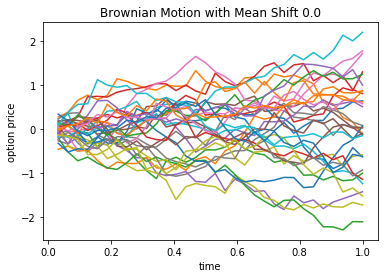

In [8]:
plt_bm_is(measure)

### Monte Carlo with Importance Sampling

In [9]:
mean_shift_is = 1
distribution = Sobol(dimension)
measure = BrownianMotion(distribution,time_vector,mean_shift_is)
integrand = AsianCall(measure)
solution2,data2 = CubSobol_g(integrand, abs_tol, check_cone=False).integrate()
data2

Solution: 1.8034         
AsianCall (Integrand Object)
	volatility      0.500
	start_price     30
	strike_price    35
	interest_rate   0
	mean_type       arithmetic
	_dim_frac       0
Sobol (DiscreteDistribution Object)
	dimension       32
	scramble        1
	replications    0
	seed            None
	backend         mps
	mimics          StdUniform
BrownianMotion (TrueMeasure Object)
	distrib_name    Sobol
	time_vector     [ 0.031  0.062  0.094 ...  0.938  0.969  1.000]
CubSobol_g (StoppingCriterion Object)
	abs_tol         0.010
	rel_tol         0
	n_init          1024
	n_max           34359738368
CubatureData (AccumulateData Object)
	n_total         4096
	solution        1.803
	r_lag           4
	time_integrate  0.268

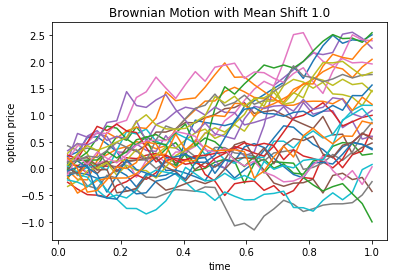

In [10]:
plt_bm_is(measure)

In [11]:
print('Imporance Sampling takes %.3f the time and %.3f the samples'%\
     (data2.time_integrate/data1.time_integrate,data2.n_total/data1.n_total))

Imporance Sampling takes 0.273 the time and 0.250 the samples


## Importance Sampling MC vs QMC

**Test Parameters**

- dimension = 16
- abs_tol = .025
- mean_shifts = arange(-.25, 3.25, .25),
- trials = 3

In [53]:
df = pd.read_csv('../outputs/mc_vs_qmc/importance_sampling_compare_mean_shifts.csv')
mean_shifts = df.mean_shift.unique()
ms_cols = [str(ms) for ms in mean_shifts]
df_samples = df.groupby(['Stopping Criterion','Distribution'])['n_samples'].apply(list).reset_index(name='n')
df_times = df.groupby(['Stopping Criterion','Distribution'])['time'].apply(list).reset_index(name='time')
df.loc[(df.mean_shift==0) | (df.mean_shift==1)].set_index('Stopping Criterion')

,Distribution,mean_shift,n_samples,time
Stopping Criterion,,,,
CLT,IIDStdUniform,0.0,323871.0,1.077637
CLT,IIDStdUniform,1.0,82218.0,0.490676
CLT,IIDStdGaussian,0.0,372201.0,0.638598
CLT,IIDStdGaussian,1.0,87311.0,0.273390
CLTRep,Lattice,0.0,8192.0,1.244883
CLTRep,Lattice,1.0,2048.0,0.077035
CLTRep,Sobol,0.0,2048.0,0.181789
CLTRep,Sobol,1.0,1024.0,0.052719
MeanMC_g,IIDStdUniform,0.0,422240.0,1.375361


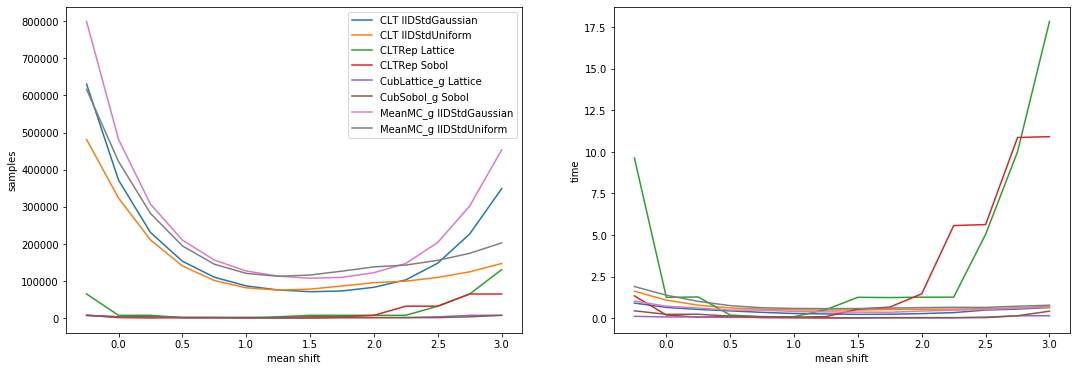

In [57]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df_samples.apply(lambda row: ax[0].plot(mean_shifts,row.n,label='%s %s'%tuple(row[[0,1]])),axis=1)
df_times.apply(lambda row: ax[1].plot(mean_shifts,row.time,label='%s %s'%tuple(row[[0,1]])),axis=1)
ax[0].legend()
ax[0].set_ylabel('samples')
ax[1].set_ylabel('time')
for i in range(0,2): ax[i].set_xlabel('mean shift')
#plt.savefig('../outputs/importance_sampling/vary_mean_shift.png',dpi=200)